In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import pymongo
from pymongo import MongoClient
import pprint as pp
! pip install normalise
import nltk
nltk.download('names')
nltk.download('brown')

import numpy as np
import multiprocessing as mp

import string
import spacy 
import en_core_web_sm
from nltk.tokenize import word_tokenize
from sklearn.base import TransformerMixin, BaseEstimator
from normalise import normalise
import re
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,GRU, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras import layers

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd '/content/drive/My Drive/minor2/Hate-Speech-Content-Moderation/'

/content/drive/My Drive/minor2/Hate-Speech-Content-Moderation


In [0]:
df1=pd.read_excel('wiki.xlsx')
#df1.drop(['level_0','index','Unnamed: 0'],axis=1,inplace=True)
df1.head()

,id,text,label
0,4873f24af8928f39,Oh BedWetter... please stop your furious back-...,1
1,aa343515b55c73b8,"There's no conflict, a court martial can end w...",0
2,c7888738107f928a,what????how are the ones from willking1979's t...,0
3,48a42a867206a816,"""\n\nabuse or consentual??\n\n""""Homolka would ...",0
4,2c103909d79f9876,"""==Talk:""""Lane Splitting""""==\n\nDennis, why do...",1


In [0]:
np.mean(df1['label'])

0.29870638965111723

In [0]:
text=df1['text']
labels=df1['label']

In [0]:
nlp = en_core_web_sm.load()


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 variety="BrE",
                 user_abbrevs={},
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Text normalization
            2. Punctuation removal
            3. Stop words removal
            4. Lemmatization
        
        variety - format of date (AmE - american type, BrE - british format) 
        user_abbrevs - dict of user abbreviations mappings (from normalise package)
        n_jobs - parallel jobs to run
        """
        self.variety = variety
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()
        return X_copy.apply(self._preprocess_text)

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        text=self._clean_text(text)
        normalized_text = self._normalize(text)
        doc = nlp(normalized_text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

    def _normalize(self, text):
        # some issues in normalise package
        try:
            return ' '.join(normalise(text, variety=self.variety, user_abbrevs=self.user_abbrevs, verbose=False))
        except:
            return text

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]

    def _lemmatize(self, doc):
        return ' '.join([t.lemma_ for t in doc])
    
    
    def _clean_text(self,text):
      replace_1 = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
      replace_2 = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
      text=re.sub(r"http\S+", "", text)
      text = replace_1.sub("", text)
      text = replace_2.sub(" ", text)
      text=re.sub('\s+',' ',text)
      return text

In [0]:
%%time
text = TextPreprocessor(n_jobs=-1).transform(df1['text'])

CPU times: user 2min 54s, sys: 1.31 s, total: 2min 55s
Wall time: 2min 55s


In [0]:
exdf=pd.DataFrame()
exdf['text']=["hello my \n is ./.,is tushit's \t @344$%% what are you D.R   running  doing?? please HELP!!"]
clean_ex = TextPreprocessor(n_jobs=-1).transform(exdf['text'])
print(clean_ex[0])

In [0]:
text=text.tolist()

In [0]:
text2=[]
for i in text:
    lst=i.split()
    text2.append(lst)

In [0]:
from gensim.models import FastText
model_fasttext = FastText(text2, size=100, window=5, min_count=5, workers=4,sg=0)
words = list(model_fasttext.wv.vocab)
print('Vocabulary size:', len(words))

Vocabulary size: 6374


In [0]:
model_fasttext.wv.save_word2vec_format('/content/drive/My Drive/minor2/Hate-Speech-Content-Moderation/trained_fastext(wiki).txt',binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
embeddings_index={}
f= open('/content/drive/My Drive/minor2/Hate-Speech-Content-Moderation/trained_fastext(wiki).txt',encoding='utf-8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.array(values[1:])
  embeddings_index[word]=coefs
f.close

<function TextIOWrapper.close>

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(text2)
sequences = tokenizer_obj.texts_to_sequences(text2)
max_length = max([len(s.split()) for s in text])
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.',len(word_index))

tweets_pad = pad_sequences(sequences,maxlen=max_length)

Found %s unique tokens. 32848


In [0]:
df3=pd.concat([pd.DataFrame(text),pd.DataFrame(tweets_pad)],axis=1)

In [0]:
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words,100))

for word , i in word_index.items():
  if i > num_words:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i]=embedding_vector

In [0]:
embedding_matrix.shape

(32849, 100)

In [0]:
print(num_words)

32849


In [0]:
model = Sequential()
embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer = Constant(embedding_matrix),
                            weights = [embedding_matrix],
                            input_length = max_length,
                            trainable=False)
model.add(embedding_layer)
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1250, 100)         3284900   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1246, 128)         64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 3,350,329
Trainable params: 65,429
Non-trainable params: 3,284,900
_________________________________________________________________


In [0]:
model = Sequential()
embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_length,
                            trainable=False)
model.add(embedding_layer)
model.add(LSTM(units=100))
model.add(Dropout(.3))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1250, 100)         3284900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 3,365,401
Trainable params: 80,501
Non-trainable params: 3,284,900
_________________________________________________________________


In [0]:
model = Sequential()
embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_length,
                            trainable=False)
model.add(embedding_layer)
model.add(GRU(units=100,dropout=0.2 , recurrent_dropout=0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1250, 100)         3284900   
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 3,345,301
Trainable params: 60,401
Non-trainable params: 3,284,900
_________________________________________________________________


In [0]:
model = Sequential()
embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_length,
                            trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(layers.Dense(10, activation='relu'))
#model.add(GRU(units=100,dropout=0.2 , recurrent_dropout=0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1250, 100)         3284900   
_________________________________________________________________
flatten_1 (Flatten)          (None, 125000)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1250010   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 4,534,921
Trainable params: 1,250,021
Non-trainable params: 3,284,900
_________________________________________________________________


In [0]:
model = Sequential()
embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_length,
                            trainable=False)
model.add(embedding_layer)
#model.add(Flatten())
model.add(SimpleRNN(32, dropout=.2, recurrent_dropout=.2))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
optimiz = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiz,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1250, 100)         3284900   
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 32)                4256      
_________________________________________________________________
dense_13 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 3,289,497
Trainable params: 4,597
Non-trainable params: 3,284,900
_________________________________________________________________


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_testing ,y_train, y_testing = train_test_split(df3, labels, test_size = 0.60, random_state = 1)

In [0]:
X_test, X_val ,y_test, y_val = train_test_split(X_testing, y_testing, test_size = 0.50, random_state = 0)

In [0]:
print('Training.....')
history=model.fit(X_train.iloc[:,1:], y_train, batch_size=256,epochs=5,validation_data=(X_val.iloc[:,1:],y_val),verbose=True)

Training.....
Train on 4081 samples, validate on 3062 samples
Epoch 1/5
4081/4081 [==============================] - 14s 3ms/step - loss: nan - accuracy: 0.0225 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/5
4081/4081 [==============================] - 14s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/5
4081/4081 [==============================] - 14s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/5
4081/4081 [==============================] - 14s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/5
4081/4081 [==============================] - 14s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00


In [0]:
loss, accuracy = model.evaluate(X_test.iloc[:,1:], y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

3061/3061 [==============================] - 9s 3ms/step
Testing Accuracy:  0.8494


In [0]:
y_classes = model.predict_classes(X_test.iloc[:,1:])

In [0]:
set(y_val)

{0, 1}

In [0]:
dataset = pd.DataFrame({'y_test': y_test, 'y_classes': y_classes[:,0]})

In [0]:
df_x=dataset[dataset['y_test']==dataset['y_classes']]
df_x[df_x['y_classes']==0]

In [0]:
dataset[dataset['y_test']==1]

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [0]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_classes)
print('Accuracy:{}\n'.format(accuracy))
# precision tp / (tp + fp)
precision = precision_score(y_test, y_classes)
print('Precision:{}\n'.format(precision))
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_classes)
print('Recall:{}\n'.format(recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_classes)
print('F1 score:{}\n'.format(f1))
matrix = confusion_matrix(y_test, y_classes)
print("Confusion Matrix:")
print(matrix)

Accuracy:0.8294674942829141

Precision:0.742296918767507

Recall:0.6105990783410138

F1 score:0.6700379266750948

Confusion Matrix:
[[2009  184]
 [ 338  530]]


In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history,name_of_fig):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    f=plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    f.savefig(name_of_fig, bbox_inches='tight', dpi=400)

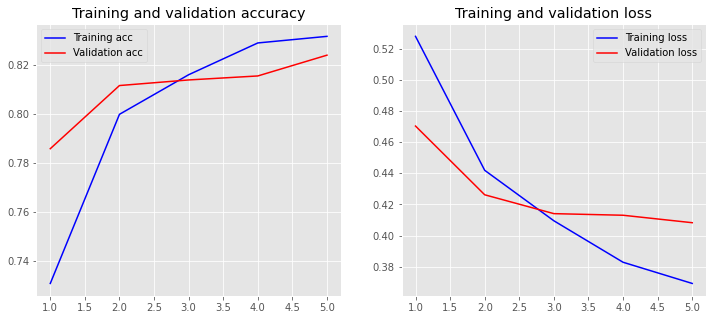

In [0]:
plot_history(history,'/content/drive/My Drive/minor2/Hate-Speech-Content-Moderation/accuracy and losses graphs(fasttext_MLP).jpg')